# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras import models as ml
from keras import layers as l

from sklearn import preprocessing as pp
from sklearn import metrics as m
from sklearn import model_selection as ms

from xgboost import XGBClassifier

from scipy.stats import chi2_contingency
from scikitplot import metrics as mt

## 0.1 Importing Data

In [2]:
users_raw = pd.read_csv('D:\\My Drive\\Pessoal\\projetos\\airbnb_first_booking_predict\\data\\raw\\train_users_2.csv')
sessions_raw = pd.read_csv('D:\\My Drive\\Pessoal\\projetos\\airbnb_first_booking_predict\\data\\raw\\sessions.csv')

## 0.2 Helper Functions

In [3]:
# correlations between categorical attributes by Pearson method
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    return round(np.sqrt((chi2corr/n)/( min(kcorr-1, rcorr-1))), 2)

# 1.0 Data Description

In [4]:
users1 = users_raw.copy()
sessions1 = sessions_raw.copy()

## 1.1 Looking Dataset

In [5]:
users1.head(5)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


* A data da criação da conta em alguns casos é posterior a data do primeiro booking

In [6]:
sessions1.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


## 1.2 Data Dimension

In [7]:
print('Usuários')
print(f'Há: {users1.shape[0]} linhas no total')
print(f'Há: {users1.shape[1]} colunas no total')

Usuários
Há: 213451 linhas no total
Há: 16 colunas no total


In [8]:
print('Sessions')
print(f'Há: {sessions1.shape[0]} linhas no total')
print(f'Há: {sessions1.shape[1]} colunas no total')

Sessions
Há: 10567737 linhas no total
Há: 6 colunas no total


## 1.3 Datatypes

In [9]:
print('Usuários')
users1.dtypes

Usuários


id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [10]:
print('Navegação')
sessions1.dtypes

Navegação


user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.4 Check Na

In [11]:
print('Usuários')
users1.isna().sum()  / users1['id'].count()

Usuários


id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [12]:
print('Sessions')
sessions1.isna().sum() / sessions1['user_id'].count()

Sessions


user_id          0.003275
action           0.007559
action_type      0.106919
action_detail    0.106919
device_type      0.000000
secs_elapsed     0.012914
dtype: float64

* action_type e action_detail possuem a mesma quantidade de NaN's, aparentemente ou são altamente correlacionadas ou são derivadas de uma mesma característica

## 1.5 Filout Na

### 1.5.1 Users

In [13]:
users1_qtd_base = users1.shape[0]

<AxesSubplot:>

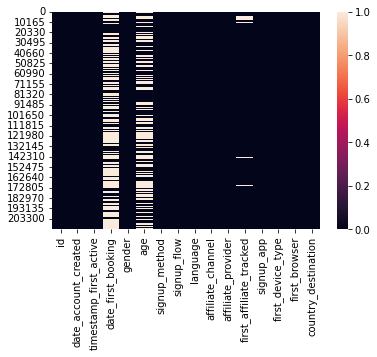

In [14]:
sns.heatmap(users1.isna())

#### 1.5.1 date_first_booking

In [15]:
users1[users1['date_first_booking'].isna()]['country_destination'].value_counts()

NDF    124543
Name: country_destination, dtype: int64

Usuários que ainda não fizeram um "booking" são classificados como "NDF (No Destination Found)", e são NaN's em date_first_booking. Para completar os dados dessa feature, em um ambiente empresarial real o input dos dados faltantes dessa feature se daria pela data atual, como o dataset é de dados históricos, os dados serão inputados com a data máxima do dataset.

#### 1.5.2 age

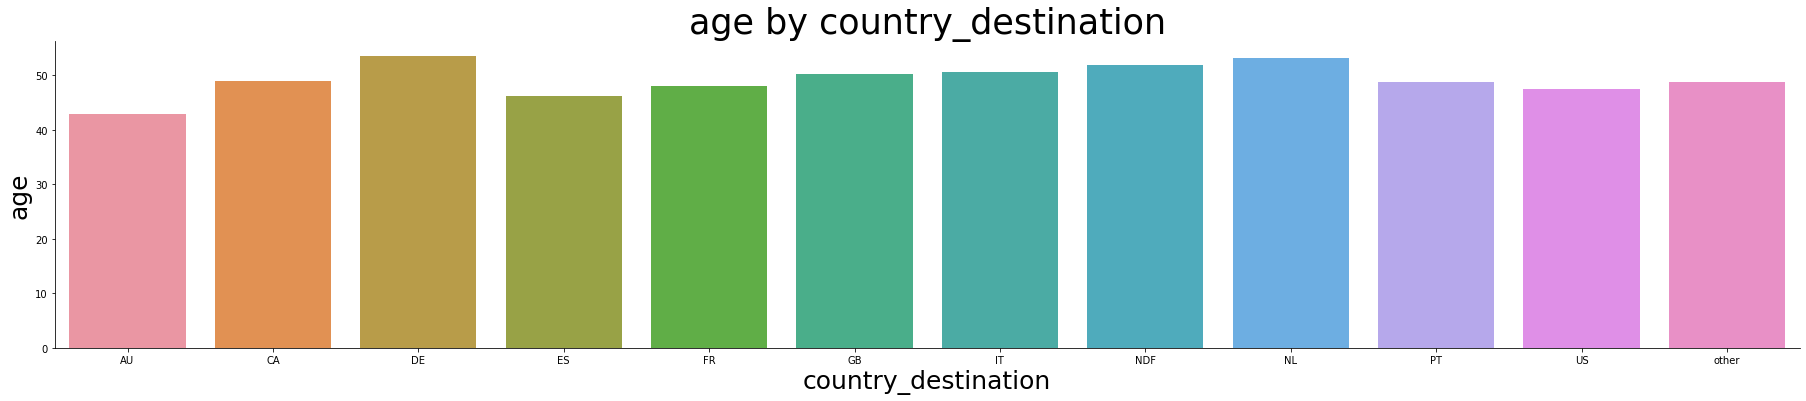

In [16]:
temp = users1.groupby('country_destination').agg({'age': 'mean'}).reset_index()
sns.catplot(data=temp, x='country_destination', y='age', kind='bar', aspect=5)
plt.title('age by country_destination', fontsize=35)
plt.xlabel('country_destination', fontsize=25)
plt.ylabel('age', fontsize=25);

A distribuição parece uniforme em todas as categorias de country_destination

D:\My Drive\Pessoal\environments\data_science\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


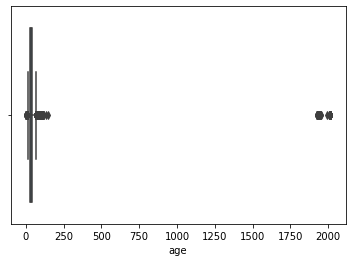

In [17]:
# plt.figure(figsize=(20, 5))
sns.boxplot(users1['age']);

* Outliers com idade de 2000 anos, erros de input

In [18]:
print(f'Média = {users1["age"].mean()}')
print(f'Mediana = {users1["age"].median()}')

Média = 49.66833517985669
Mediana = 34.0


* Bastante deslocadas por conta dos outliers

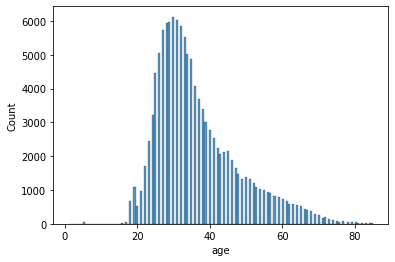

In [19]:
# plt.figure(figsize=(20, 5))
sns.histplot(users1.loc[users1['age']<=85, 'age']);

Parecida com uma NORMAL, apesar de possuir um SKEW POSITIVO (cauda direita mais pesada). Uma distribuição NORMAL com média e desvio padrão similares pode ser uma boa forma de substituição dos Nas

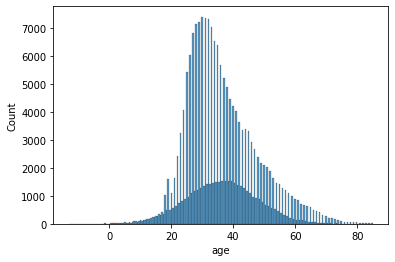

In [20]:
loc = users1.loc[users1['age']<=85, 'age'].mean()
scale = users1.loc[users1['age']<=85, 'age'].std()
size = temp = users1.loc[users1['age'].isna()]['id'].count()
random_norm_age = np.random.normal(loc=loc, scale=scale, size=size)
temp = users1.copy()
temp.loc[users1['age'].isna(), 'age'] = random_norm_age

sns.histplot(temp.loc[temp['age']<=85, 'age']);

#### 1.5.3 first_affiliate_tracked

In [21]:
users1['first_affiliate_tracked'].value_counts()

untracked        109232
linked            46287
omg               43982
tracked-other      6156
product            1556
marketing           139
local ops            34
Name: first_affiliate_tracked, dtype: int64

In [22]:
users1[users1['first_affiliate_tracked'].isna()]['country_destination'].value_counts()

NDF      4327
US       1309
FR        124
other     113
IT         44
CA         37
ES         36
GB         29
DE         20
AU         12
NL         11
PT          3
Name: country_destination, dtype: int64

As amostras NaN's estão dispesas em todas as categorias de países destinos. Uma abortagem para este problema seria o input utilizando a frequência por categoria de country_destination, porém, tratando-se de uma variável categórica, onde há uma chance grande de inputarmos junto com isso um viés, e tratando-se de uma porcentagem baixa em relação ao total da base, droparemos as amostras com NaN's nessa feature.

#### 1.5.4 Filout Na

In [23]:
# date_first_booking
users1['date_account_created'] = pd.to_datetime(users1['date_account_created'])
temp = users1['date_account_created'].max().strftime('%Y-%m-%d')
users1['date_first_booking'].fillna(temp, inplace=True)

# age
loc = users1.loc[users1['age']<=85, 'age'].mean()
scale = users1.loc[users1['age']<=85, 'age'].std()
size = temp = users1.loc[users1['age'].isna()]['id'].count()
random_norm_age = np.random.normal(loc=loc, scale=scale, size=size)
users1.loc[users1['age'].isna(), 'age'] = random_norm_age

# first_affiliate_tracked
users1 = users1[~users1['first_affiliate_tracked'].isna()]

print(f'Porcentagem da base removida: {round((users1_qtd_base - users1.shape[0]) * 100/ users1_qtd_base, 2)}%')

Porcentagem da base removida: 2.84%


### 1.5.2 Sessions

In [24]:
sessions1_qtd_base = sessions1.shape[0]

<AxesSubplot:>

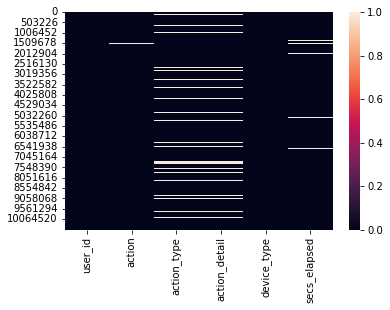

In [25]:
sns.heatmap(sessions1.isna())

* action_type e action_detail são NaN's juntamente

#### 1.5.2.1 user_id

user_id é a chave para a concatenação com users, portanto não há outra alternativa para o drop

#### 1.5.2.2 action

action possui somente 0.007 de NaN's, portanto será removida

#### 1.5.2.3 action_type e action_detail

In [26]:
sessions1['action_type'].value_counts()

view                3560902
data                2103770
click               1996183
-unknown-           1031170
submit               623357
message_post          87103
partner_callback      19132
booking_request       18773
modify                 1139
booking_response          4
Name: action_type, dtype: int64

In [27]:
sessions1.loc[sessions1['action_type'].isna(), 'action'].value_counts()

show                      582144
similar_listings_v2       168788
lookup                    162041
campaigns                 104709
track_page_view            81117
index                      16733
localization_settings       5403
uptodate                    3342
signed_out_modal            1058
currencies                   292
update                       225
check                        120
braintree_client_token       120
widget                        75
phone_verification            16
satisfy                        9
track_activity                 6
disaster_action                6
Name: action, dtype: int64

Diversificado demais para poder descobrir um padrão de reconhecimento de falha em action_type olhando para a action de origem. Provavelmente o que ocorre nas variáveis de sessions é uma arvore de classes onde o pai das classes é a action, e as outras variáveis são classificações dentro de action, e nem toda action possui uma classificação de action_type ou action_detail. Será criada uma categoria nova do tipo "without classification"

#### 1.5.2.4 secs_elapsed

secs_elapsed possui somente 0.01 de NaN's, portanto será removida

#### 1.5.2.5 Filout NaN's

In [28]:
# 'user_id'
sessions1 = sessions1.loc[~sessions1['user_id'].isna()]

# 'action'
sessions1 = sessions1.loc[~sessions1['action'].isna()]

# 'action_type'
sessions1.loc[sessions1['action_type'].isna(), 'action_type'] = 'without_classification'

# 'action_detail'
sessions1.loc[sessions1['action_detail'].isna(), 'action_detail'] = 'without_classification'

# 'secs_elapsed'
sessions1 = sessions1.loc[~sessions1['secs_elapsed'].isna()]

print(f'Porcentagem da base removida: {round((sessions1_qtd_base - sessions1.shape[0]) * 100/ sessions1_qtd_base, 2)}%')

Porcentagem da base removida: 2.21%


## 1.6 Changing datatype

### 1.6.1 users

In [29]:
# date_account_created
users1['date_account_created'] = pd.to_datetime(users1['date_account_created'])

# timestamp_first_active
users1['timestamp_first_active'] = pd.to_datetime(users1['timestamp_first_active'], format='%Y%m%d%H%M%S')
users1['timestamp_first_active'] = pd.to_datetime(users1['timestamp_first_active']).dt.strftime('%Y-%m-%d')

# date_first_booking
users1['date_first_booking'] = pd.to_datetime(users1['date_first_booking'])

# age
users1['age'] = users1['age'].astype(int)

### 1.6.2 sessions

## 1.7 Check Balanced Data

In [30]:
users1['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

## 1.8 Descriptive Statistic

### 1.8.1 users

#### 1.8.1.1 Numerical Attributes

In [31]:
users_num_attributes = users1.select_dtypes(include=[int, float]).columns.to_list()

In [32]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(users1[users_num_attributes].apply(np.mean)).T
ct2 = pd.DataFrame(users1[users_num_attributes].apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(users1[users_num_attributes].apply(np.std)).T
d2 = pd.DataFrame(users1[users_num_attributes].apply(min)).T
d3 = pd.DataFrame(users1[users_num_attributes].apply(max)).T
d4 = pd.DataFrame(users1[users_num_attributes].apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(users1[users_num_attributes].apply(lambda x: x.skew())).T
d6 = pd.DataFrame(users1[users_num_attributes].apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
m.columns = 'min max range mean median std skew kurtosis'.split()
m

,min,max,range,mean,median,std,skew,kurtosis
age,-9.0,2014.0,2023.0,43.894834,35.0,118.825472,16.299667,266.885528
signup_flow,0.0,25.0,25.0,3.151490,0.0,7.543915,2.287158,3.567794


* age com números negativos, e pessoas máxima com erro também, média e mediana bastante deslocadas por conta de outliers, desvio padrão altíssimo, skew alta positiva, o que sugere causa direita mais pesada e kurtosis com um pico muito elevado. Os dados sugerem uma POISON com erros de input. Por exemplo, a idade máxima parece estar bastante ligada ao ano da data atual.
* signup_flow com range de 25, média de 3.15 e mediana de 0, o que indicam muitos valores zerados, skew e kurtosis sugerem uma Normal, mas considerando os outros parâmetros, deve estar mais próxima a uma POISON

#### 1.8.1.2 Cattegorical Attributes

In [33]:
users_cat_attributes = users1.select_dtypes(exclude=[int, float, 'datetime64[ns]']).columns.to_list()
users_cat_attributes.remove('id')

In [34]:
users1[users_cat_attributes].describe().T

,count,unique,top,freq
timestamp_first_active,207386,1635,2014-05-13,672
gender,207386,4,-unknown-,91783
signup_method,207386,3,basic,148297
language,207386,25,en,200415
affiliate_channel,207386,8,direct,134179
affiliate_provider,207386,18,direct,133935
first_affiliate_tracked,207386,7,untracked,109232
signup_app,207386,4,Web,178334
first_device_type,207386,9,Mac Desktop,89600
first_browser,207386,52,Chrome,63845


* linguage, affiliate_provider e first_browser com muitas dimensões 

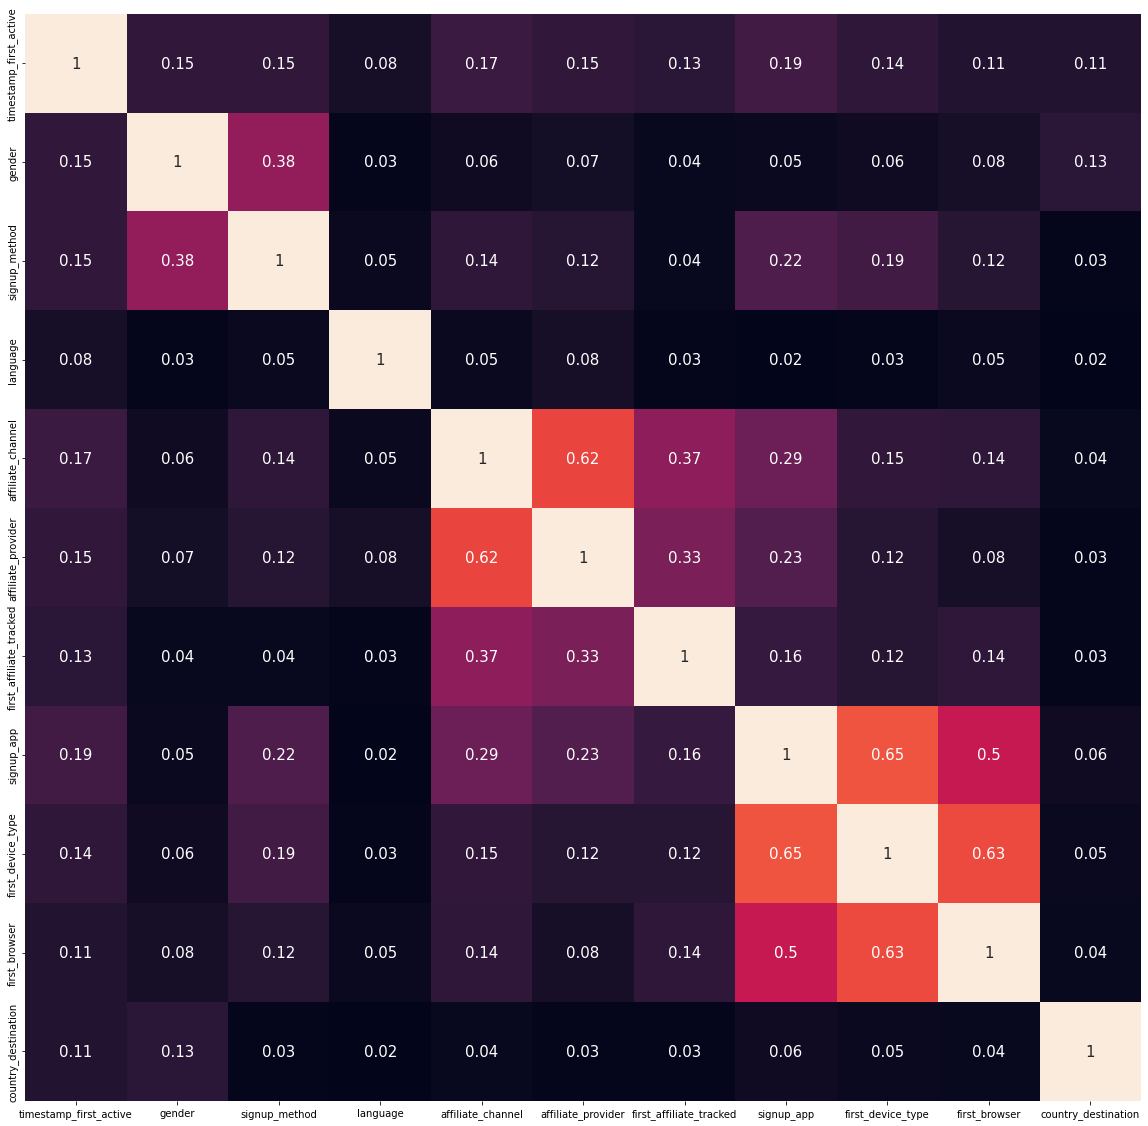

In [35]:
cramer_correlation = []
temp = users1[users_cat_attributes]
n_cols = len(temp.columns.to_list())

for i, col_1 in enumerate(temp[users_cat_attributes]):
    for j, col_2 in enumerate(temp[users_cat_attributes]):
        cramer_correlation.append(cramer_v(temp[col_1], temp[col_2]))
        
matrix = pd.DataFrame(np.array(cramer_correlation).reshape(n_cols, n_cols), index=users_cat_attributes, columns=users_cat_attributes)

plt.figure(figsize=(20, 20))
sns.heatmap(matrix, annot=True, cbar=False, annot_kws={'fontsize':15});

Correlações no máximo altas.

### 1.8.2 sessions

#### 1.8.2.1 Numerical Attributes

In [36]:
sessions_num_attributes = sessions1.select_dtypes(include=[int, float]).columns.to_list()

In [37]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(sessions1[sessions_num_attributes].apply(np.mean)).T
ct2 = pd.DataFrame(sessions1[sessions_num_attributes].apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(sessions1[sessions_num_attributes].apply(np.std)).T
d2 = pd.DataFrame(sessions1[sessions_num_attributes].apply(min)).T
d3 = pd.DataFrame(sessions1[sessions_num_attributes].apply(max)).T
d4 = pd.DataFrame(sessions1[sessions_num_attributes].apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(sessions1[sessions_num_attributes].apply(lambda x: x.skew())).T
d6 = pd.DataFrame(sessions1[sessions_num_attributes].apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
m.columns = 'min max range mean median std skew kurtosis'.split()
m

,min,max,range,mean,median,std,skew,kurtosis
secs_elapsed,0.0,1799977.0,1799977.0,18852.061447,1132.0,87471.902045,11.377108,161.061418


* sects_elapse com valores zerados, o que não faz sentido para o negócio, skew e kurtosis super altos, média e mediana extremamente deslocados, range gigantesco.

#### 1.8.2.2 Cattegorical Attributes

In [38]:
sessions_cat_attributes = sessions1.select_dtypes(exclude=[int, float, 'datetime64[ns]']).columns.to_list()
sessions_cat_attributes.remove('user_id')

In [39]:
sessions1[sessions_cat_attributes].describe()

,action,action_type,action_detail,device_type
count,10333696,10333696,10333696,10333696
unique,359,11,156,14
top,show,view,view_search_results,Mac Desktop
freq,2758841,3545621,1770931,3513600


* muitas dimensões em action e action_detail, o que dificulta a parte de encoding

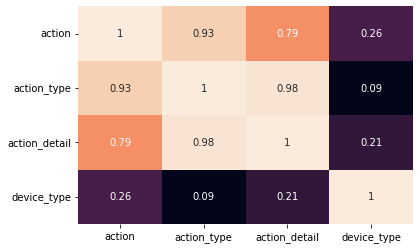

In [40]:
cramer_correlation = []
temp = sessions1[sessions_cat_attributes]
n_cols = len(temp.columns.to_list())

for i, col_1 in enumerate(temp[sessions_cat_attributes]):
    for j, col_2 in enumerate(temp[sessions_cat_attributes]):
        cramer_correlation.append(cramer_v(temp[col_1], temp[col_2]))
        
matrix = pd.DataFrame(np.array(cramer_correlation).reshape(n_cols, n_cols), index=sessions_cat_attributes, columns=sessions_cat_attributes)

# plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, cbar=False);

* action e action_type altamente correlacionadas, o que sugere que carreguem o mesmo tipo de informação, possivelmente seja mais interessnate trabalhar somente com uma das duas, para manter coerência de acordo com a Navalha de Occam
* mesmo caso com action_type e action_detail 

## 1.9 Concatenation and Data Description Integral Dataframe

In [41]:
sessions1.rename(columns = {'user_id':'id'}, inplace=True)

In [42]:
sessions1
df1 = users1.merge(sessions1, how='left', on='id')

### 1.9.1 Looking dataframe

In [43]:
df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,action,action_type,action_detail,device_type,secs_elapsed
0,gxn3p5htnn,2010-06-28,2009-03-19,2014-06-30,-unknown-,35,facebook,0,en,direct,...,untracked,Web,Mac Desktop,Chrome,NDF,NaN,NaN,NaN,NaN,NaN
1,820tgsjxq7,2011-05-25,2009-05-23,2014-06-30,MALE,38,facebook,0,en,seo,...,untracked,Web,Mac Desktop,Chrome,NDF,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,2010-09-28,2009-06-09,2010-08-02,FEMALE,56,basic,3,en,direct,...,untracked,Web,Windows Desktop,IE,US,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,2011-12-05,2009-10-31,2012-09-08,FEMALE,42,facebook,0,en,direct,...,untracked,Web,Mac Desktop,Firefox,other,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,2010-09-14,2009-12-08,2010-02-18,-unknown-,41,basic,0,en,direct,...,untracked,Web,Mac Desktop,Chrome,US,NaN,NaN,NaN,NaN,NaN


### 1.9.2 Data Dimensions

In [44]:
print(f'Há: {df1.shape[0]} linhas no total')
print(f'Há: {df1.shape[1]} colunas no total')

Há: 5558128 linhas no total
Há: 21 colunas no total


### 1.9.3 Check NaN's

In [45]:
df1.isna().sum() / df1['id'].count()

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.000000
gender                     0.000000
age                        0.000000
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.000000
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
action                     0.024311
action_type                0.024311
action_detail              0.024311
device_type                0.024311
secs_elapsed               0.024311
dtype: float64

### 1.9.4 FIlout NaN Values

In [46]:
df1.dropna(inplace=True)

### 1.9.5 Data Types

In [47]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active             object
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
action                             object
action_type                        object
action_detail                      object
device_type                        object
secs_elapsed                      float64
dtype: object

### 1.9.6 Changing Dtypes

In [48]:
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'])

# 2.0 Feature Engineering

In [49]:
df2 = df1.copy()

# 3.0 Exploratory Data Analysis

In [50]:
df3 = df2.copy()

* A data da criação da conta em alguns casos é posterior a data do primeiro booking
* Age Outliers com idade de 2000 anos, erros de input
* Age Bastante deslocadas por conta dos outliers
* age com números negativos, e pessoas máxima com erro também, média e mediana bastante deslocadas por conta de outliers, desvio padrão altíssimo, skew alta positiva, o que sugere causa direita mais pesada e kurtosis com um pico muito elevado. Os dados sugerem uma POISON com erros de input. Por exemplo, a idade máxima parece estar bastante ligada ao ano da data atual.
* signup_flow com range de 25, média de 3.15 e mediana de 0, o que indicam muitos valores zerados, skew e kurtosis sugerem uma Normal, mas considerando os outros parâmetros, deve estar mais próxima a uma POISON
* action_type e action_detail possuem a mesma quantidade de NaN's, aparentemente ou são altamente correlacionadas ou são derivadas de uma mesma característica
* action_type e action_detail são NaN's juntamente
* muitas dimensões em action e action_detail, o que dificulta a parte de encoding
* linguage, affiliate_provider e first_browser com muitas dimensões 
* action e action_type altamente correlacionadas, o que sugere que carreguem o mesmo tipo de informação, possivelmente seja mais interessnate trabalhar somente com uma das duas, para manter coerência de acordo com a Navalha de Occam
* mesmo caso com action_type e action_detail 
* sects_elapse com valores zerados, o que não faz sentido para o negócio, skew e kurtosis super altos, média e mediana extremamente deslocados, range gigantesco.

# 4.0 Data Filtering

In [51]:
df4 = df3.copy()

## 4.1 Filtering Rows

## 4.2 Columns Selection

# 5.0 Data Preparation

In [52]:
df5 = df4.copy()

## 5.2 Target

## 5.3 Features

In [53]:
df5.columns.to_list()

['id',
 'date_account_created',
 'timestamp_first_active',
 'date_first_booking',
 'gender',
 'age',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination',
 'action',
 'action_type',
 'action_detail',
 'device_type',
 'secs_elapsed']

### 5.3.1 Normalize

### 5.3.2 Standard Scaler

### 5.3.3 Encoding

## 5.4 Preprocessing

In [ ]:
X = df5.drop(['id', 'country_destination'], axis=1)
y = df5['country_destination']
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=100)

# 6.0 Feature Selection

In [ ]:
df6 = df5.copy()

In [ ]:
cols_drop = 'date_account_created timestamp_first_active date_first_booking'.split()
df6.drop(cols_drop, axis=1, inplace=True)

# 7.0 Machine Learning Modeling

In [ ]:
df7 = df6.copy()

## 7.1 Preprocessing

In [ ]:
X = df7.drop(['id', 'country_destination'], axis=1)
y = df7['country_destination']

## 7.2 Models

### 7.2.1 Baseline Model

In [ ]:
# train test split
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=100)

# random y_hat weighted
p = y_train.value_counts(normalize=True).sort_index().values
a = y_train.drop_duplicates().sort_index().sort_values()
y_hat = np.random.choice(a=a, size=len(y_test), p=p)

# metrics
acc = m.accuracy_score(y_test, y_hat)
balanced_acc = m.balanced_accuracy_score(y_test, y_hat)
kappa = m.cohen_kappa_score(y_test, y_hat)

print(f'Accuracy: {acc}')
print(f'Balanced Accuracy: {balanced_acc}')
print(f'Kappa Score : {kappa}')
print('')
print(f'{m.classification_report(y_test, y_hat)}')

mt.plot_confusion_matrix(y_test, y_hat, normalize=False, figsize=(9, 9));

### 7.2.2 Neural Network MLP

#### 7.2.2.1 Neural Network Single Validation

In [ ]:
# train test split
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=100)

# encoding y
ohe = pp.OneHotEncoder()
ohe_y = ohe.fit(y.values.reshape(-1, 1))
y_train_nn = ohe_y.transform(y_train.values.reshape(-1, 1)).toarray()

# model definition
nn_model = ml.Sequential()
nn_model.add(l.Dense(128, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(l.Dense(12, activation='softmax'))

# model compile
nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

# fiting model
nn_model.fit(X_train, y_train_nn, epochs=30, verbose=0, batch_size=32)

# predicting
y_hat = nn_model.predict(X_test)

# formating
y_hat = ohe.inverse_transform(y_hat)
y_hat = y_hat.reshape(1, -1)[0]
y_test_nn = y_test.to_numpy()

# metrics
acc = m.accuracy_score(y_test_nn, y_hat)
balanced_acc = m.balanced_accuracy_score(y_test_nn, y_hat)
kappa = m.cohen_kappa_score(y_test_nn, y_hat)
    
# prints
print(f'Accuracy: {acc}')
print(f'Balanced Accuracy: {balanced_acc}')
print(f'Kappa Score : {kappa}')
print('')
print(f'{m.classification_report(y_test_nn, y_hat)}')
mt.plot_confusion_matrix(y_test_nn, y_hat, normalize=False, figsize=(9, 9));

#### 7.2.2.2 Neural Network Crossvalidation

In [ ]:
acc_list, balanced_acc_list, kappa_list = [], [], []

num_folds = 5
i = 1
skf = ms.StratifiedKFold(n_splits= num_folds, random_state=100, shuffle=True)

for train_index, test_index in skf.split(X, y):
    
    # get fold
    X_train_fold = X.iloc[train_index]
    y_train_fold = y.iloc[train_index]
    
    X_test_fold = X.iloc[test_index]
    y_test_fold = y.iloc[test_index]
  

    # encoding y
    y_train_fold = ohe_y.transform(y_train_fold.values.reshape(-1, 1)).toarray()
    
    # model definition
    nn_model = ml.Sequential()
    nn_model.add(l.Dense(128, input_dim=X_train_fold.shape[1], activation='relu'))
    nn_model.add(l.Dense(12, activation='softmax'))

    # model compile
    nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

    # fiting model
    nn_model.fit(X_train_fold, y_train_fold, epochs=30, verbose=0, batch_size=32)

    # predicting
    y_hat = nn_model.predict(X_test_fold)

    # formating
    y_hat = ohe_y.inverse_transform(y_hat)
    y_hat = y_hat.reshape(1, -1)[0]
    y_test_fold = y_test_fold.to_numpy()
    
    # metrics
    acc = m.accuracy_score(y_test_fold, y_hat)
    acc_list.append(acc)
    balanced_acc = m.balanced_accuracy_score(y_test_fold, y_hat)
    balanced_acc_list.append(balanced_acc)
    kappa = m.cohen_kappa_score(y_test_fold, y_hat)
    kappa_list.append(kappa)
    
    # prints
    print(f'Fold Number: {i}')
    print(f'Balanced Accuracy: {balanced_acc}')
    print(f'Kappa Score : {kappa}\n')
    i += i

### 7.2.1 XGBoost Classifier

#### 7.2.3.1 XGBoost Classifier Sigle Validation

In [ ]:
# # encoding y
# le_y = pp.LabelEncoder().fit(y)

# y_train_le = le_y.transform(y_train)
# y_test_le = le_y.transform(y_test)

# # model defition
# xgb_model = XGBClassifier()

# # fiting model
# xgb_fit = xgb_model.fit(X_train, y_train_le)

# # predicting
# y_hat = xgb_fit.predict(X_test)

# # formating
# y_hat = le_y.inverse_transform(y_hat)

# # metrics
# acc = m.accuracy_score(y_test, y_hat)
# balanced_acc = m.balanced_accuracy_score(y_test, y_hat)
# kappa = m.cohen_kappa_score(y_test, y_hat)
    
# # prints
# print(f'Accuracy: {acc}')
# print(f'Balanced Accuracy: {balanced_acc}')
# print(f'Kappa Score : {kappa}')
# print('')
# print(f'{m.classification_report(y_test, y_hat)}');

# mt.plot_confusion_matrix(y_test, y_hat, normalize=False, figsize=(9, 9));

#### 7.2.3.2 XGBoost Classifier Crossvalidation

In [ ]:
# acc_list, balanced_acc_list, kappa_list = [], [], []

# num_folds = 5
# i = 1
# skf = ms.StratifiedKFold(n_splits= num_folds, random_state=100, shuffle=True)

# for train_index, test_index in skf.split(X, y):
    
#     # get fold
#     X_train_fold = X.iloc[train_index]
#     y_train_fold = y.iloc[train_index]
    
#     X_test_fold = X.iloc[test_index]
#     y_test_fold = y.iloc[test_index]
    
#     # encoding y
#     y_train_fold_le = le_y.transform(y_train_fold)
    
#     # model defition
#     xgb_model = XGBClassifier()
    
#     # fiting model
#     xgb_fit = xgb_model.fit(X_train_fold, y_train_fold_le)

#     # predicting
#     y_hat = xgb_fit.predict(X_test_fold)
    
#     # formating
#     y_hat = le_y.inverse_transform(y_hat)
    
#     # metrics
#     acc = m.accuracy_score(y_test_fold, y_hat)
#     acc_list.append(acc)
#     balanced_acc = m.balanced_accuracy_score(y_test_fold, y_hat)
#     balanced_acc_list.append(balanced_acc)
#     kappa = m.cohen_kappa_score(y_test_fold, y_hat)
#     kappa_list.append(kappa)
    

#     # prints
#     print(f'Fold Number: {i}')
#     print(f'Balanced Accuracy: {balanced_acc}')
#     print(f'Kappa Score : {kappa}\n')
#     i += i

# 8.0 Model Performance

## 8.1 Machine Learning Performance